In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier


In [3]:

data = pd.read_csv('input/creditcard.csv')

In [4]:
scaler = StandardScaler()
data['Amount'] = scaler.fit_transform(data['Amount'].values.reshape(-1, 1))

In [17]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.244964,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.342475,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.160686,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.140534,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,-0.073403,0


In [5]:
X = data.drop('Class', axis=1)
y = data['Class']

In [18]:
data["Class"].value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

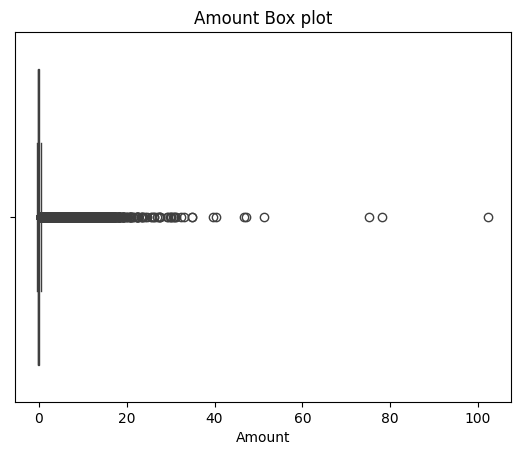

In [19]:
sns.boxplot(data,x="Amount")
plt.title("Amount Box plot")
plt.show()

In [20]:
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN

In [21]:

X = data.drop('Class', axis=1)
y = data['Class']

smote = SMOTEENN()
X_smote, y_smote = smote.fit_resample(X, y)

print(X_smote.shape)
print(y_smote.shape)

KeyboardInterrupt: 

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
from sklearn.impute import SimpleImputer

# Impute missing values in the features
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test) 

In [8]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

In [9]:
y_train_imputed = y_train.fillna(y_train.mean())

In [10]:
print("Number of NaN values in X_train_scaled:", np.isnan(X_train_scaled).sum())
print("Number of NaN values in X_test_scaled:", np.isnan(X_test_scaled).sum())

Number of NaN values in X_train_scaled: 0
Number of NaN values in X_test_scaled: 0


In [11]:
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'Support Vector Machine': SVC(),
    'Neural Network': MLPClassifier()
}

In [12]:
# Convert continuous labels to binary labels
threshold = 0.5  # Set a threshold to determine fraud (1) and non-fraud (0)
y_train_binary = (y_train_imputed > threshold).astype(int)

# Model training and evaluation
results = {}
for name, model in models.items():
    # Fit the model to the training data with binary labels
    model.fit(X_train_scaled, y_train_binary)

    if isinstance(model, SVC) and not model.probability:
        # Use decision_function instead
        y_pred_scores = model.decision_function(X_test_scaled)
        y_pred_proba = (y_pred_scores - y_pred_scores.min()) / (y_pred_scores.max() - y_pred_scores.min())  # Normalize scores
    else:
        # Use predict_proba for other models
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

    y_pred = model.predict(X_test_scaled)
    cm = confusion_matrix(y_test, y_pred)
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall, precision)

    results[name] = {'confusion_matrix': cm, 'precision_recall_auc': pr_auc}


In [13]:
for name, result in results.items():
    print(name)
    print("AUPRC:", result['precision_recall_auc'])
    print("Confusion Matrix:")
    print(result['confusion_matrix'])
    print()

Logistic Regression
AUPRC: 0.7556363067979398
Confusion Matrix:
[[56854    10]
 [   43    55]]

Random Forest
AUPRC: 0.8691948093595768
Confusion Matrix:
[[56861     3]
 [   21    77]]

Gradient Boosting
AUPRC: 0.6366963098614076
Confusion Matrix:
[[56843    21]
 [   39    59]]

Support Vector Machine
AUPRC: 0.8525225028235092
Confusion Matrix:
[[56862     2]
 [   37    61]]

Neural Network
AUPRC: 0.8529783243516905
Confusion Matrix:
[[56854    10]
 [   22    76]]



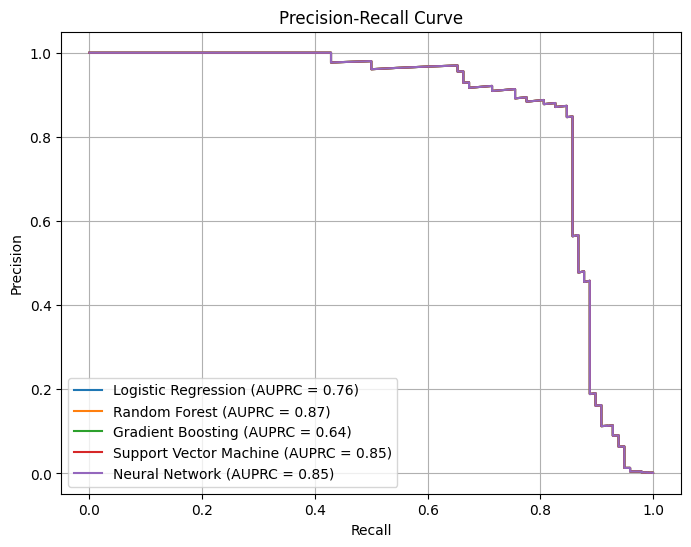

In [14]:
plt.figure(figsize=(8, 6))

for name, result in results.items():
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    plt.plot(recall, precision, label=f"{name} (AUPRC = {result['precision_recall_auc']:.2f})")

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
from sklearn.metrics import accuracy_score

accuracies = {}
for name, model in models.items():
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies[name] = accuracy

print("Model Accuracies:")
for name, accuracy in accuracies.items():
    print(f"{name}: {accuracy:.4f}")

Model Accuracies:
Logistic Regression: 0.9991
Random Forest: 0.9996
Gradient Boosting: 0.9989
Support Vector Machine: 0.9993
Neural Network: 0.9994


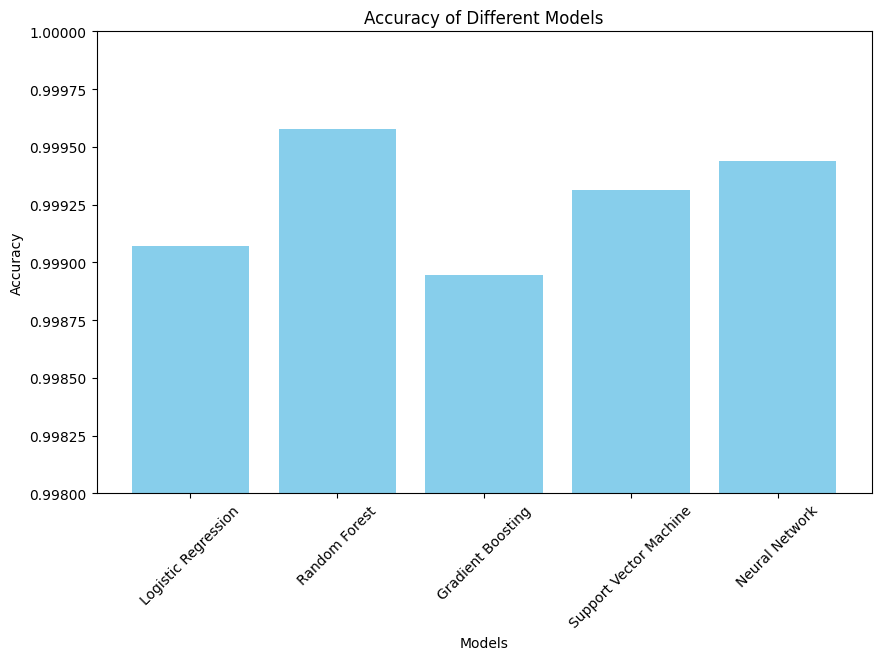

In [16]:
import matplotlib.pyplot as plt

# Extract model names and accuracy scores
model_names = list(accuracies.keys())
accuracy_scores = list(accuracies.values())

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(model_names, accuracy_scores, color='skyblue')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Accuracy of Different Models')
plt.ylim(0.998, 1)  # Set y-axis limits to better visualize differences
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()